In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import glob
import numpy as np
from matplotlib import pyplot
from PIL import Image

In [0]:
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "/content/drive/My Drive/8536_project/CelebA/Img/img_align_celeba.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip:  
    if os.path.isdir('img_align_celeba') == 0:
    # extracting all the files 
      print('Extracting all the files now...') 
      zip.extractall() 
      print('Done!') 
    else:
      print('File has already extracted.')

Extracting all the files now...
Done!


In [0]:
data_path = sorted(glob.glob('img_align_celeba/*.jpg'))
# print(len(data_path))

label_path = "/content/drive/My Drive/8536_project/CelebA/Anno/list_attr_celeba.txt"
label_list = open(label_path).readlines()[2:]
data_label = []
for i in range(len(label_list)):
  data_label.append(label_list[i].split())

for m in range(len(data_label)):
  data_label[m] = [n.replace('-1', '0') for n in data_label[m]][1:]
  data_label[m] = [int(p) for p in data_label[m]]

attributes = open(label_path).readlines()[1].split()

In [0]:
import torch
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
class celeba(Dataset):
  def __init__(self, data_path=None, label_path=None):
    self.data_path = data_path
    self.label_path = label_path

    # Data transforms
    self.transform = transforms.Compose(
        [transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
   
  def __len__(self):
    return len(self.data_path)
  
  def __getitem__(self, idx):
    image_set = Image.open(self.data_path[idx])
    image_tensor = self.transform(image_set)
    image_label = torch.Tensor(self.label_path[idx])

    return image_tensor, image_label


In [0]:
dataset = celeba(data_path, data_label)
# split data into train, valid, test set 7:2:1
indices = list(range(202599))
split_train = 141819
split_valid = 182339
train_idx, valid_idx, test_idx = indices[:split_train], indices[split_train:split_valid], indices[split_valid:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=train_sampler)

validloader = torch.utils.data.DataLoader(dataset, sampler=valid_sampler)

testloader =  torch.utils.data.DataLoader(dataset, sampler=test_sampler)

print(len(trainloader))
print(len(validloader))
print(len(testloader))


2216
40520
20260


In [0]:
def train(model, epochs, train_all_losses, train_all_acc):
    model.train()
    # initial the running loss
    running_loss = 0.0
    # pick each data from trainloader i: batch index/ data: inputs and labels
    correct = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = torch.Tensor(labels)
        # print(type(labels))
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        # print statistics
        running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update parameters
        optimizer.step()
        
        result = outputs > 0.5
        correct += (result == labels).sum().item() 

        if i % 64 == 0: 
            print('Training set: [Epoch: %d, Data: %6d] Loss: %.3f' %
                  (epochs + 1, i * 64, loss.item()))
 
    acc = correct / (split_train * 40)
    running_loss /= len(trainloader)
    train_all_losses.append(running_loss)
    train_all_acc.append(acc)
    print('\nTraining set: Epoch: %d, Accuracy: %.2f %%' % (epochs + 1, 100. * acc))


In [0]:
def validation(model, val_all_losses, val_all_acc, best_acc):
    model.eval()
    validation_loss = 0.0
    correct = 0
    for data, target in validloader:
        data = data.to('cuda')
        target = target.to('cuda')
        output = model(data)

        validation_loss += criterion(output, target).item()

        result = output > 0.5
        correct += (result == target).sum().item()


    validation_loss /= len(validloader)
    acc = correct / (len(validloader) * 40)

    val_all_losses.append(validation_loss)
    val_all_acc.append(acc)

    
    print('\nValidation set: Average loss: {:.3f}, Accuracy: {:.2f}%)\n'
          .format(validation_loss, 100. * acc))
    
    return acc

In [0]:
def test(model, attr_acc, attr_name=attributes):
    test_loss = 0
    correct = 0
    pred = []
    for data, target in testloader:
        data = data.to('cuda')
        target = target.to('cuda')
        output = model(data)
        test_loss += criterion(output, target).item()

        result = output > 0.5
        correct += (result == target).sum().item()
        compare = (result == target)
        pred.append(compare[0])


    test_loss /= len(testloader)
    acc = correct / (len(testloader) * 40)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(
        test_loss, 100. * acc))
    
    for m in range(len(attr_name)):
        num = 0
        for n in range(len(pred)):
            if pred[n][m]:
                num += 1
        accuracy = num / len(pred)
        attr_acc.append(accuracy)

    for i in range(len(attr_acc)):
        print('Attribute: %s, Accuracy: %.3f' % (attr_name[i], attr_acc[i]))


In [0]:
# mish activation function
class mish(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x * (torch.tanh(F.softplus(x)))



def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        mish()
    )


def conv_dw(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        mish(),
    
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        mish()
    )


class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()

        self.features = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )

        self.fc = nn.Linear(1024, 40)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x


In [0]:
# define empty list to store the losses and accuracy for ploting
train_all_losses2 = []
train_all_acc2 = []
val_all_losses2 = []
val_all_acc2 = []
test_all_losses2 = 0.0
# define the training epoches
epochs = 10

In [0]:
# instantiate Net class
mobilenet = MobileNet()
# use cuda to train the network
mobilenet.to('cuda')
#loss function and optimizer
criterion = nn.BCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [0]:
!pip install memory-profiler
%load_ext memory_profiler

     |████████████████████████████████| 40kB 2.6MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.55.0-cp36-none-any.whl size=27174 sha256=0725af6dc669e2f22b4b4ddd2c9b28c8a8a777b453abad20b7949713973c5781
  Stored in directory: /root/.cache/pip/wheels/f0/ff/63/fdbff3f1e1b76ad4eae491dd5b190902906b093e93eb86dd5a
Successfully built memory-profiler


In [0]:
%%timeit
best_acc = 0.0
for epoch in range(epochs):
    train(mobilenet, epoch, train_all_losses2, train_all_acc2)
    acc = validation(mobilenet, val_all_losses2, val_all_acc2, best_acc)
    if acc > best_acc:
      checkpoint_path = './model_checkpoint.pth'
      best_acc = acc
      # save the model and optimizer
      torch.save({'model_state_dict': mobilenet.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)
      print('new best model saved')
    print("========================================================================")

Training set: [Epoch: 1, Data:      0] Loss: 0.704
Training set: [Epoch: 1, Data:   4096] Loss: 0.383
Training set: [Epoch: 1, Data:   8192] Loss: 0.290
Training set: [Epoch: 1, Data:  12288] Loss: 0.278
Training set: [Epoch: 1, Data:  16384] Loss: 0.287
Training set: [Epoch: 1, Data:  20480] Loss: 0.279
Training set: [Epoch: 1, Data:  24576] Loss: 0.273
Training set: [Epoch: 1, Data:  28672] Loss: 0.248
Training set: [Epoch: 1, Data:  32768] Loss: 0.247
Training set: [Epoch: 1, Data:  36864] Loss: 0.243
Training set: [Epoch: 1, Data:  40960] Loss: 0.248
Training set: [Epoch: 1, Data:  45056] Loss: 0.239
Training set: [Epoch: 1, Data:  49152] Loss: 0.234
Training set: [Epoch: 1, Data:  53248] Loss: 0.231
Training set: [Epoch: 1, Data:  57344] Loss: 0.234
Training set: [Epoch: 1, Data:  61440] Loss: 0.242
Training set: [Epoch: 1, Data:  65536] Loss: 0.245
Training set: [Epoch: 1, Data:  69632] Loss: 0.223
Training set: [Epoch: 1, Data:  73728] Loss: 0.238
Training set: [Epoch: 1, Data: 

KeyboardInterrupt: ignored

In [0]:
checkpoint_path = './model_checkpoint.pth'
model = MobileNet().to('cuda')
checkpoint = torch.load(checkpoint_path)
print("model load successfully.")

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()
attr_acc = []
test(model, attr_acc=attr_acc)

model load successfully.

Test set: Average loss: 1.1293, Accuracy: 79.13%

Attribute: 5_o_Clock_Shadow, Accuracy: 0.906
Attribute: Arched_Eyebrows, Accuracy: 0.600
Attribute: Attractive, Accuracy: 0.510
Attribute: Bags_Under_Eyes, Accuracy: 0.821
Attribute: Bald, Accuracy: 0.966
Attribute: Bangs, Accuracy: 0.945
Attribute: Big_Lips, Accuracy: 0.694
Attribute: Big_Nose, Accuracy: 0.829
Attribute: Black_Hair, Accuracy: 0.778
Attribute: Blond_Hair, Accuracy: 0.917
Attribute: Blurry, Accuracy: 0.951
Attribute: Brown_Hair, Accuracy: 0.635
Attribute: Bushy_Eyebrows, Accuracy: 0.749
Attribute: Chubby, Accuracy: 0.828
Attribute: Double_Chin, Accuracy: 0.901
Attribute: Eyeglasses, Accuracy: 0.985
Attribute: Goatee, Accuracy: 0.938
Attribute: Gray_Hair, Accuracy: 0.976
Attribute: Heavy_Makeup, Accuracy: 0.484
Attribute: High_Cheekbones, Accuracy: 0.841
Attribute: Male, Accuracy: 0.928
Attribute: Mouth_Slightly_Open, Accuracy: 0.919
Attribute: Mustache, Accuracy: 0.936
Attribute: Narrow_Eyes, Ac

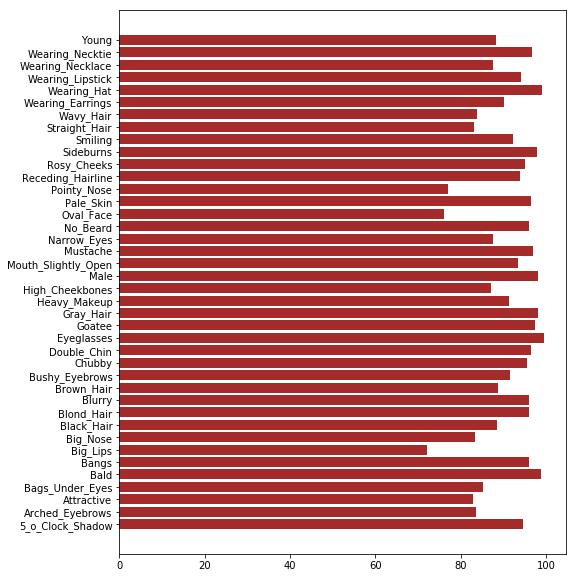

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 10))
plt.barh(range(40), [100 * acc for acc in attr_acc], tick_label = attributes, fc = 'brown')
plt.show()

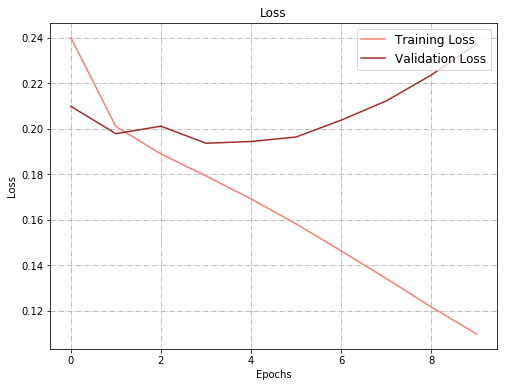

In [0]:
plt.figure(figsize=(8, 6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True, linestyle='-.')
plt.plot(train_all_losses2, c='salmon', label = 'Training Loss')
plt.plot(val_all_losses2, c='brown', label = 'Validation Loss')
plt.legend(fontsize='12', loc='upper right')
plt.show()

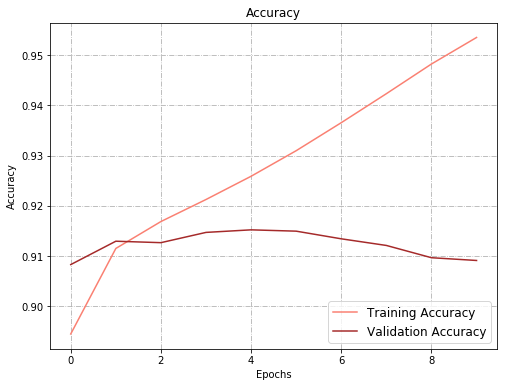

In [0]:
plt.figure(figsize=(8, 6))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True, linestyle='-.')
plt.plot(train_all_acc2, c='salmon', label = 'Training Accuracy')
plt.plot(val_all_acc2, c='brown', label = 'Validation Accuracy')
plt.legend(fontsize='12', loc='lower right')
plt.show()

In [0]:
# test images on the Model
transform = transforms.Compose(
        [transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
         
image_set = Image.open('/content/test.jpg')

image_tensor = transform(image_set)
image = torch.unsqueeze(image_tensor, 0)
image = image.to('cuda')
output = model(image)
result = output > 0.5
result = result.cpu().numpy()


for t in range(len(attributes)):
    if result[0][t] == True:
       print("Attribute: \033[1;35m%s \033[0m, \033[1;35m%s \033[0m" % (attributes[t], result[0][t]))
    else:
       print("Attribute: %s, %s" % (attributes[t], result[0][t]))

Attribute: 5_o_Clock_Shadow, False
Attribute: Arched_Eyebrows, False
Attribute: Attractive , True 
Attribute: Bags_Under_Eyes, False
Attribute: Bald, False
Attribute: Bangs, False
Attribute: Big_Lips, False
Attribute: Big_Nose, False
Attribute: Black_Hair , True 
Attribute: Blond_Hair, False
Attribute: Blurry, False
Attribute: Brown_Hair, False
Attribute: Bushy_Eyebrows , True 
Attribute: Chubby , True 
Attribute: Double_Chin, False
Attribute: Eyeglasses, False
Attribute: Goatee, False
Attribute: Gray_Hair, False
Attribute: Heavy_Makeup , True 
Attribute: High_Cheekbones, False
Attribute: Male, False
Attribute: Mouth_Slightly_Open , True 
Attribute: Mustache, False
Attribute: Narrow_Eyes, False
Attribute: No_Beard , True 
Attribute: Oval_Face , True 
Attribute: Pale_Skin, False
Attribute: Pointy_Nose, False
Attribute: Receding_Hairline, False
Attribute: Rosy_Cheeks , True 
Attribute: Sideburns, False
Attribute: Smiling , True 
Attribute: Straight_Hair , True 
Attribute: Wavy_Hair, Fals